# 3 задание
## Цель:
    Провести анализ данных и оценить результаты A/B-теста для нового фунĸционала в мобильном приложении ритейл-сети.

## Анализ в Python
*  Проведите оценĸу A/B-теста с использованием t-теста
* 
— Постройте визуализац
    * и:
Распределение среднего чеĸа по гру
    * ам.
Объём продаж по грĸционал.ых.

## Подготовка данных

In [97]:
# либы для манипуляции с данными
import pandas as pd
from scipy import stats 

# либы для визуала
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid") #ticks без сетки
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1)

In [26]:
# Определяем датасеты
df_users = pd.read_csv('users.csv')
df_transactions = pd.read_csv('transactions.csv')
df_ab = pd.read_csv('ab_groups.csv')

In [215]:
df_users.head()

,user_id,region,registration_date
0,1,Новосибирск,2024-11-15
1,2,Екатеринбург,2024-04-15
2,3,Москва,2024-06-12
3,4,Москва,2024-07-20
4,5,Екатеринбург,2023-07-11


В этой таблице ничего нужного для ответа на вопросы

In [217]:
df_transactions.head()

,transaction_id,user_id,transaction_date,amount,group
0,1,2114,2024-10-19,9052,B
1,2,6117,2024-08-24,2120,A
2,3,1614,2024-09-10,1066,A
3,4,9900,2024-11-05,3945,A
4,5,3415,2024-10-16,7030,B


In [221]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_id    50000 non-null  int64 
 1   user_id           50000 non-null  int64 
 2   transaction_date  50000 non-null  object
 3   amount            50000 non-null  int64 
 4   group             50000 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.9+ MB


In [233]:
df_transactions[df_transactions['user_id'] == 2]

,transaction_id,user_id,transaction_date,amount,group
1259,1260,2,2024-11-09,7066,B
6350,6351,2,2024-08-22,6636,A
7335,7336,2,2024-11-12,4276,B
8653,8654,2,2024-11-05,2629,A
20682,20683,2,2024-10-15,7908,A
30415,30416,2,2024-10-10,5302,B
37376,37377,2,2024-10-23,5671,A


In [272]:
# проверяем сколько уникальных групп у клиента
df_transactions.groupby('user_id').group.nunique().max()

2

Видно, что у 1 и того же клиента в этой таблице в после group стоят разные группы, значит использовать это поле для определения группы в тесте пользователя нельзя

In [219]:
df_ab.head()

,user_id,group
0,1,A
1,2,B
2,3,B
3,4,B
4,5,B


In [238]:
# соединяем 2 таблицы, чтобы получить в итоге транзакции с правильной группой пользователя в тесте
df_transactions_groups = df_transactions.merge(df_ab, on = 'user_id')

In [254]:
df_transactions_groups = df_transactions_groups.drop(columns = ['group_x'])

In [260]:
df_transactions_groups.columns = ['transaction_id', 'user_id', 'transaction_date', 'amount', 'group']

In [270]:
# проверяем сколько уникальных групп у клиента
df_transactions_groups.groupby('user_id').group.nunique().max()

1

## Работа с данными. Расчеты и визуал

Нулевая гипотеза: средний чек в обеих группах одинаковый.
Возьмем классическое значени pvalue = 0.05, чтобы отвергать или принимать нулевую гипотезу

In [275]:
# определяем наши группы и используем функцию для подсчета ttest
a_group = df_transactions_groups[df_transactions_groups['group'] == 'A']['amount']
b_group = df_transactions_groups[df_transactions_groups['group'] == 'B']['amount']

res = stats.ttest_ind(a_group, b_group)

In [277]:
# прописываем условия и показываем результаты
print('Средний чек группы А: {:.2f}'.format(a_group.mean()))
print('Средний чек группы B: {:.2f}'.format(b_group.mean()))
print('pvalue = {:.5f}'.format(res[1]))
print('')
if res[1] > 0.05:
    print('Нулевая гипотеза принимается. Средний чек обеих групп одинаковый')
elif res[1] <= 0.05: 
    print('Нулевая гипотеза отвергается. Средний чек обеих групп разный')
else:
    print('Перепроверить результаты')

Средний чек группы А: 5269.97
Средний чек группы B: 5256.32
pvalue = 0.57805

Нулевая гипотеза принимается. Средний чек обеих групп одинаковый


In [279]:
# Подготавливаем таблицу с подсчетом сколько было продаж и какой средний чек по каждой группе для визуализации
agg_sales = df_transactions_groups.groupby('group')['amount'].sum()
agg_sales = agg_sales.reset_index()

agg_mean = df_transactions_groups.groupby('group')['amount'].mean()
agg_mean = agg_mean.reset_index()

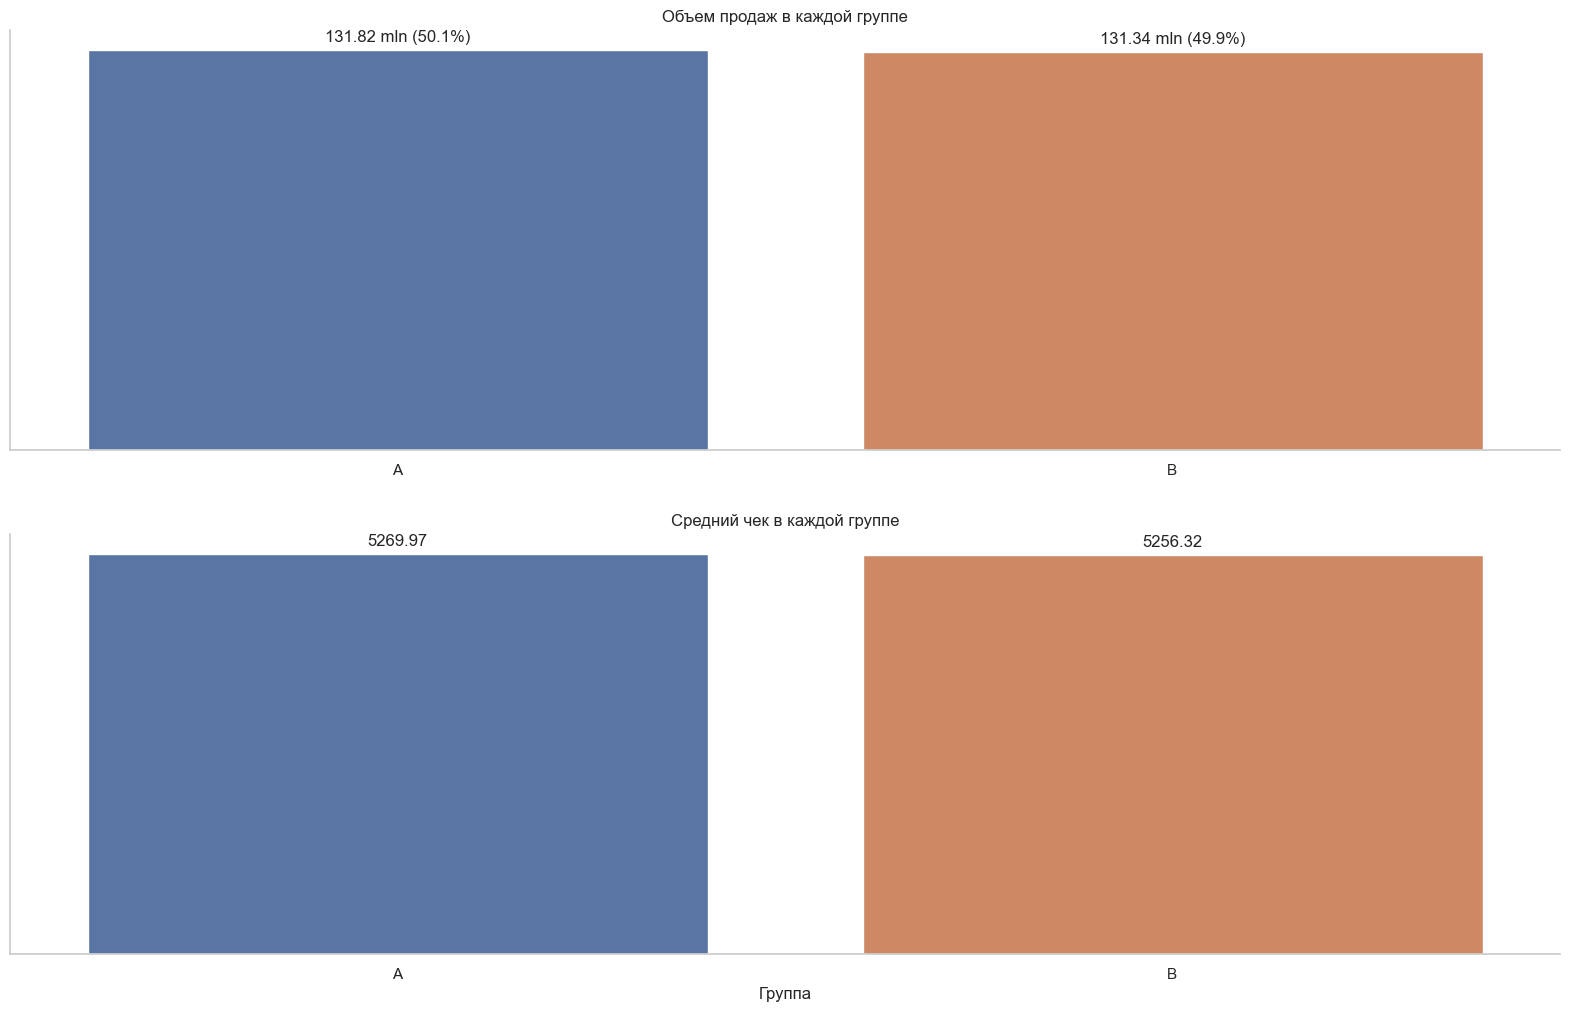

In [281]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,12))

bar = sns.barplot(data = agg_sales, x = 'group', y = 'amount', ax=ax1)

for p in bar.patches:
    bar.annotate('{:.2f} mln ({:.1%})'.format(p.get_height()/1000000, p.get_height() / agg_sales.amount.sum()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

ax1.set_title('Объем продаж в каждой группе')
ax1.set_xlabel('')
ax1.get_yaxis().set_visible(False)


bar = sns.barplot(data = agg_mean, x = 'group', y = 'amount', ax = ax2)

for p in bar.patches:
    bar.annotate('{:.2f}'.format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

ax2.set_title('Средний чек в каждой группе')
ax2.set_xlabel('Группа')
ax2.get_yaxis().set_visible(False)



plt.show()

* Объем продаж по группам почти одинаковый. Группа А 131.82 млн - это 50.1% от общего объема продаж, а группа В - 131.34 млн 49.9%
* У средних чеков между групп минимальная - 13.65 y.e. 

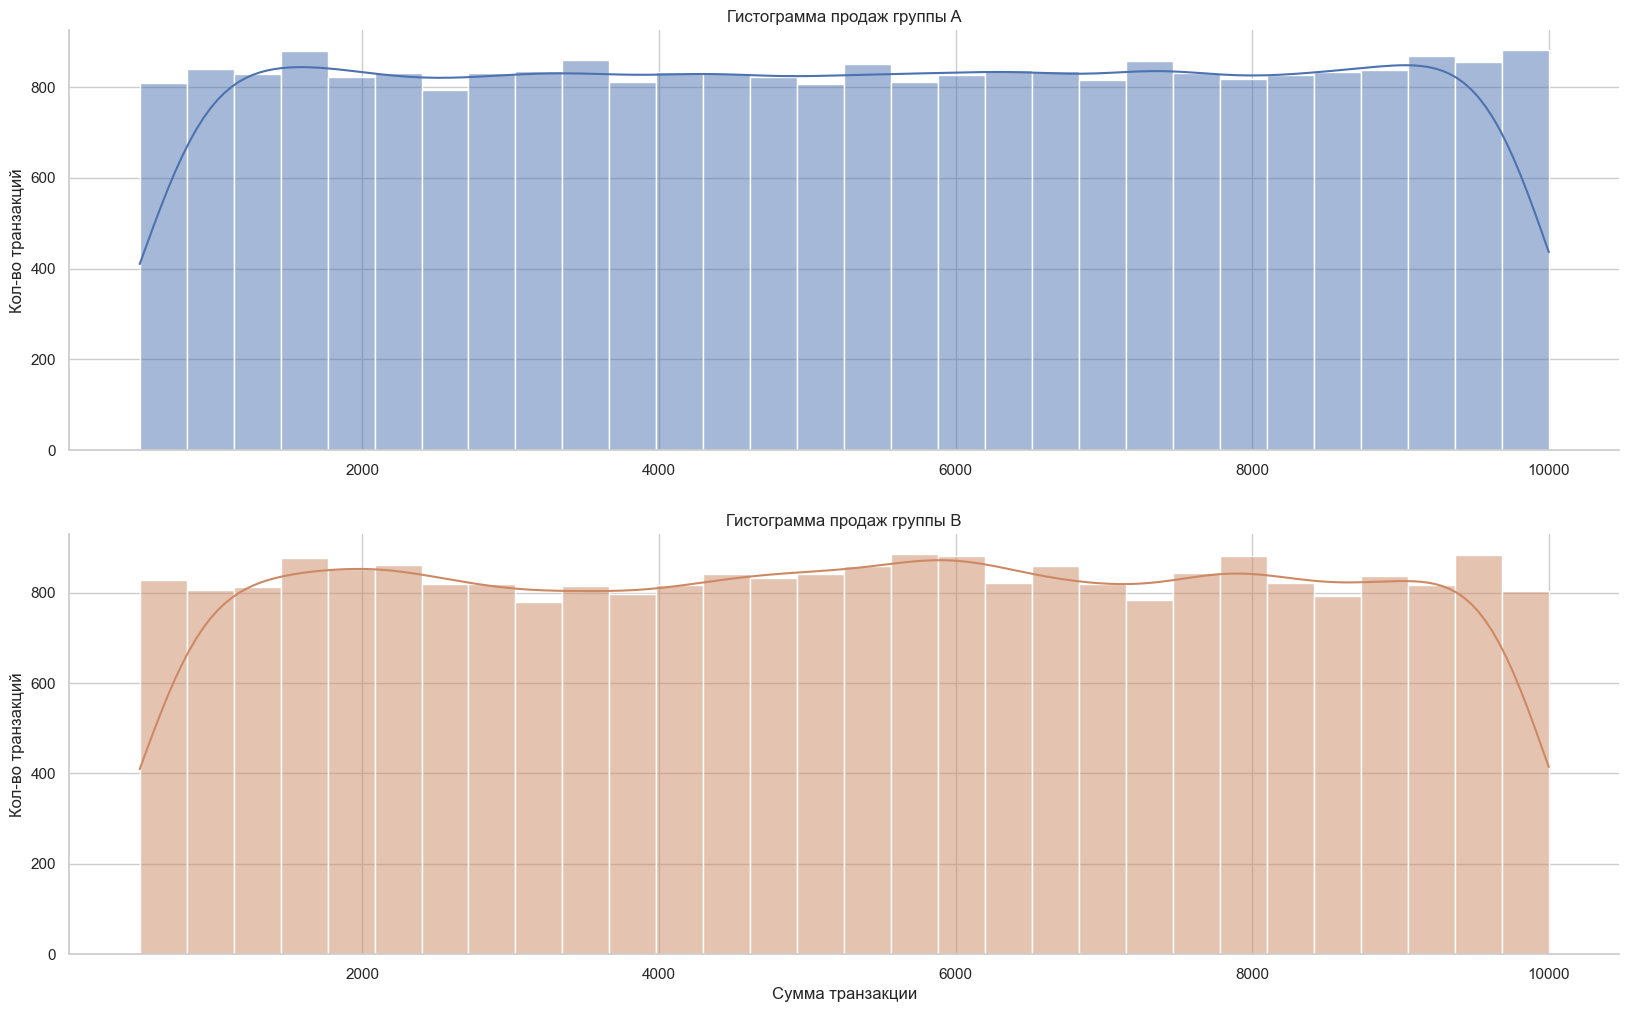

In [284]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,12))

sns.histplot(data=df_transactions_groups[df_transactions_groups['group'] == 'A'], x='amount', kde=True, ax=ax1)
ax1.set_title('Гистограмма продаж группы A')
ax1.set_xlabel('')
ax1.set_ylabel('Кол-во транзакций')

 
sns.histplot(data=df_transactions_groups[df_transactions_groups['group'] == 'B'], x='amount', kde=True, color = '#cd8964', ax=ax2)
ax2.set_title('Гистограмма продаж группы B')
ax2.set_xlabel('Сумма транзакции')
ax2.set_ylabel('Кол-во транзакций')


plt.show()

* На гистограмме видно, что есть разные суммы покупок, но количество транзакций  с их примерно одинаковое количество. Обычно денежные гистограммы перекошены в одну сторону большого количества покупок на небольшую сумму с большим хвостом редких дорогих покупок